## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path) 

In [3]:
data = pd.read_csv("Cleaned data\data.csv")

In [4]:
# drop columns
df = data.drop(columns=[
    "DATE","FORECASTDEMAND","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,1,19.05


In [5]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# function to create the sliding window dataset 
def create_sliding_window(data, window_size, step_size, target):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X_window = []
        for j in range(0, window_size, step_size):
            X_window.append(data.iloc[i-j-1, :])
        X.append(np.concatenate(X_window, axis=0))
        y.append(data.iloc[i, :]) 
    y2 = [vals[5] for vals in y]
    # display(pd.DataFrame(X))
    return pd.DataFrame(X), pd.DataFrame(y2)

In [7]:
# Define the window size and step size
target = "TOTALDEMAND"
window_size = 1   # 1 day ahead
step_size = 1     # move the window by 1 day at a time

# Apply the sliding window method
X, y = create_sliding_window(df, window_size, step_size, target)
X_all = X.copy() #save for accuracy plotting
X = X.iloc[:, 1:]

In [8]:
# train test split - use last year to train (data ends in 08/2022 so set timeframe as 08/2021 to 08/2022)
test_timeframe = df.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))]
test_len = len(test_timeframe)
X_train, X_test = X.head(len(X)-test_len), X.tail(test_len)
y_train, y_test = y.head(len(X)-test_len), y.tail(test_len)

In [9]:
# define scaler and transform data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [10]:
# Define the XGBoost model
model = xgb.XGBRegressor()

In [28]:
# hyperparameters
params = {
    'n_estimators': [180, 200, 220],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.001],
    'reg_alpha': [3, 4, 5],
    'reg_lambda': [4, 5, 6]
}

In [29]:
# identify best hyperparameters using gridsearch 
grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [30]:
# best hyperparameters and score 
print("Best Hyperparameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_) 

# prev Best Hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 220, 'reg_alpha': 4, 'reg_lambda': 5, 'subsample': 0.8}
# prev Best Score: 0.8237249155825339


Best Hyperparameters:  {'colsample_bytree': 0.9, 'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 220, 'reg_alpha': 4, 'reg_lambda': 4, 'subsample': 0.8}
Best Score:  0.8273886060785707


In [14]:
# # print all results 
# print("------ All Results ------- ")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("   %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print("------ End All Results ------- ") 

In [15]:
# train model using best hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.001, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=5, ...)

In [16]:
# predictions on test data 
y_pred = best_model.predict(X_test_scaled)

In [17]:
# print model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error: {:.2f}".format(mae))
print("Root Mean Squared Error: {:.2f}".format(rmse))

Mean Absolute Error: 315.43
Root Mean Squared Error: 390.58


#### Plot Accuracy

In [18]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

In [19]:
df_lim = X_all.tail(test_len)
df_lim.columns = df.columns
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["FORECAST"] = data["FORECASTDEMAND"].tail(test_len).shift(-1).replace(0, np.nan)
df_lim = df_lim.dropna()
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim.head()

,DATE,TOTALDEMAND,YTEST,YPRED,FORECAST
2039,2021-08-01,7335.822396,8101.526979,8001.792969,8327.524223
2040,2021-08-02,8101.526979,8077.243715,8846.851562,8331.968164
2041,2021-08-03,8077.243715,8461.227500,8334.108398,8662.525274
2042,2021-08-04,8461.227500,8231.809201,8794.195312,8467.645334
2043,2021-08-05,8231.809201,8027.316944,8629.931641,8193.368153


In [20]:
Date = [d.date() for d in df_lim.DATE]
Demand = df_lim.TOTALDEMAND
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST

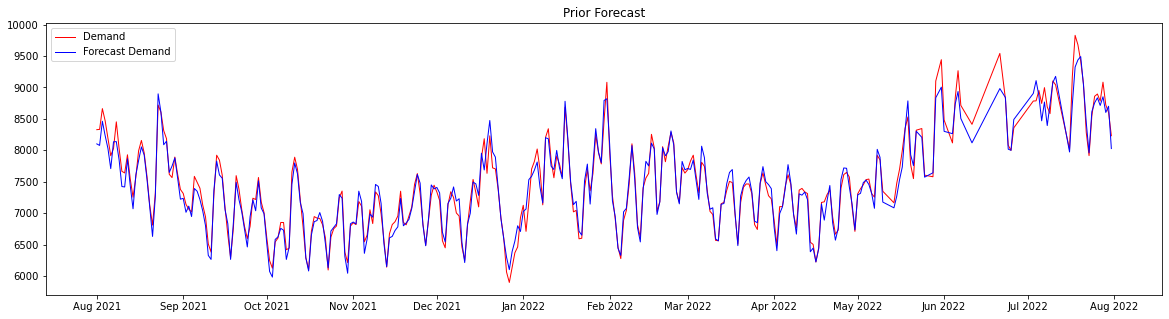

In [21]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

In [22]:
# print prior model performance
mae1 = mean_absolute_error(Test, Forecast)
mse1 = mean_squared_error(Test, Forecast)
rmse1 = np.sqrt(mse1)
print("Mean Absolute Error: {:.2f}".format(mae1))
print("Root Mean Squared Error: {:.2f}".format(rmse1))

Mean Absolute Error: 112.60
Root Mean Squared Error: 146.63


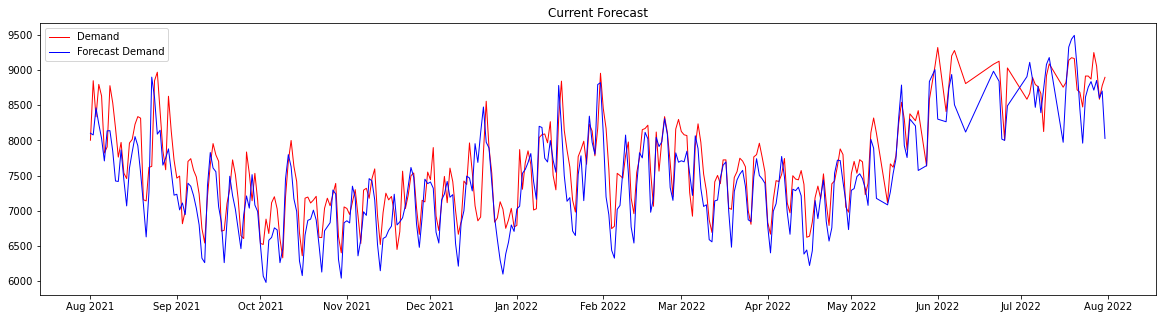

In [23]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()

In [24]:
# print current model performance
mae2 = mean_absolute_error(Test, Pred)
mse2 = mean_squared_error(Test, Pred)
rmse2 = np.sqrt(mse2)

print("Mean Absolute Error: {:.2f}".format(mae2))
print("Root Mean Squared Error: {:.2f}".format(rmse2))

Mean Absolute Error: 312.31
Root Mean Squared Error: 387.55
